In [58]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

np.set_printoptions(precision=4)

In [59]:
import json

base_path = "/home/lcw/workspace/panocam/"

scene_file= os.path.join(base_path, 'data', "/home/lcw/workspace/panocam/data.json")

with open(scene_file, 'r') as f:
    scene = json.load(f)

In [60]:
calib_file = os.path.join(base_path, '64b9fde6360457d8beddcfb06c512fec6e2989d8.json')
with open(calib_file,'r') as f:
    calib = json.load(f)

In [61]:
# For sanity check(코드가 잘 돌아가는 지 확인하는 체크)
frame = 0

sensor_idx = 0      # LiDAR
index = (frame - 1) * (6 + 1) + sensor_idx    # 10th frame, total 6 cameras + 1 LiDAR, + 1 is for offset of camera_01

datum = scene['data'][index]['datum']
pcd_lidar = np.load('/home/lcw/workspace/panocam/15616458249936530.npz')

pose_lidar = datum['point_cloud']['pose']

In [62]:
import numpy as np

frame = 1
camera_numbers = [1, 5, 6, 7, 8, 9]
datum = {}

for num in camera_numbers:
    sensor_idx = np.where(np.array(camera_numbers) == num)[0][0]
    camera_id = f"camera{num:02d}"
    index = (frame - 1) * (len(camera_numbers) + 1) + sensor_idx+1
    datum[camera_id] = scene['data'][index]['datum']
    calib[camera_id] = calib['intrinsics'][sensor_idx]


In [63]:
image_camera = {}
depth_camera = {}
intrinsics_camera = {}
extrinsics_camera ={}
pose_camera = {}

for num in camera_numbers:
    # 카메라 ID 및 파일명 설정
    sensor_idx = np.where(np.array(camera_numbers) == num)[0][0]

    camera_id = f"camera{num:02d}"
    rgb_filename = os.path.join(base_path, 'rgb', f'cam{num}.png')
    depth_filename = rgb_filename.replace('rgb', 'depth').replace('.png', '.npz')

    # RGB 이미지 로드 및 BGR에서 RGB로 변환
    stream = open(rgb_filename, "rb")
    bytes = bytearray(stream.read())
    stream.close()
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    image = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
    image_rgb = image[:, :, (2, 1, 0)]  # BGR -> RGB
    
    image_camera[camera_id] = image_rgb


    depth_camera[camera_id] = np.load(depth_filename)['depth']
    intrinsics_camera[camera_id] = calib['intrinsics'][sensor_idx+1]
    extrinsics_camera[camera_id] = calib['extrinsics'][sensor_idx+1]
    pose_camera[camera_id] = datum[camera_id]['image']['pose']
    



In [64]:
# display(Image.fromarray(image_camera['camera01']).resize(size=(image_camera['camera01'].shape[1]//4, image_camera['camera01'].shape[0]//4)))

In [65]:
# display(Image.fromarray(image_camera['camera06']).resize(size=(image_camera['camera06'].shape[1]//4, image_camera['camera06'].shape[0]//4)))

In [66]:
# Code from https://github.com/facebookresearch/pytorch3d/blob/e245560abb8f019a24880faf7557ed3b2eec6cc0/pytorch3d/transforms/rotation_conversions.py#L41-L70

def quaternion_to_matrix(quaternions: np.ndarray) -> np.ndarray:
    """Convert rotations given as quaternions to rotation matrices.

    Parameters
    ----------
    quaternions: np.ndarray (4)
        quaternions with real part first
        
    Returns
    -------
    rotation_matrix: np.ndarray (3 x 3)
        converted rotation matrix
    """
    
    r, i, j, k = quaternions
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    two_s = 2.0 / (quaternions ** 2).sum()

    o = np.array([
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
    ])
    rotation_matrix = o.reshape(3, 3)
    return rotation_matrix

In [67]:
def get_intrinsic_matrix(intrinsics):
    K = np.eye(3)
    K[0, 0] = intrinsics['fx']
    K[1, 1] = intrinsics['fy']
    K[0, 2] = intrinsics['cx']
    K[1, 2] = intrinsics['cy']
    return K

def get_pose_matrix(pose):
    quaternion = np.array([
        pose['rotation']['qw'],
        pose['rotation']['qx'],
        pose['rotation']['qy'],
        pose['rotation']['qz'],
    ])

    T_world_from_camera = np.eye(4)
    T_world_from_camera[:3, :3] = quaternion_to_matrix(quaternion)
    T_world_from_camera[ 0,  3] = pose['translation']['x']
    T_world_from_camera[ 1,  3] = pose['translation']['y']
    T_world_from_camera[ 2,  3] = pose['translation']['z']

    return T_world_from_camera

In [68]:
K_camera = {}
T_world_from_camera = {}

T_world_from_lidar = get_pose_matrix(pose_lidar)

for num in camera_numbers:
    # 카메라 ID를 문자열로 포맷팅
    camera_id = f"camera{num:02d}"
    K_camera[camera_id] = get_intrinsic_matrix(intrinsics_camera[camera_id])
    T_world_from_camera[camera_id] = get_pose_matrix(pose_camera[camera_id])


In [69]:
def get_pixel_grid(height, width, with_ones=True):
    """Create a pixel grid

    Parameters
    ----------
    height : int
        height of the grid
    width : int
        width of the grid        
    with_ones : Bool
        whether the ones are appended (homogeneous coordinate)

    Returns
    -------
    grid : np.ndarray (2 x H x W) or (3 x H x W)
        Output pixel grid
    """    
    xx, yy = np.meshgrid(
        np.linspace(0, width - 1, width),
        np.linspace(0, height - 1, height),        
        indexing='xy')    
    
    coords = [xx, yy]
    if with_ones:
        coords += [np.ones_like(xx)]
    grid = np.stack(coords, 0)
    return grid

In [70]:
def reconstruct_depth_map(depth, K, T_wc):
    """Reconstruct 3D points in world coordinate from depth map

    Parameters
    ----------
    depth : np.ndarray (H x W)
        input depth map
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_wc : np.ndarray (4 x 4)
        transformation to world coordinate from camera coordinate

    Returns
    -------
    points : np.ndarray (3 x H x W)
        output 3D points 
    """
    h, w = depth.shape
    K_inv = np.linalg.inv(K)  # (3 x 3)
    
    # Get a pixel grid (image coordinate)
    grid = get_pixel_grid(h, w, with_ones=True)
    grid = grid.reshape(3, -1)    # (3 x H x W) -> (3 x N)
        
    # Get 3D points in camera coordinate system
    #  - numpy broadcasting during element-wise multiplication
    #    : (1 x N) * (3 x N) -> (3 x N) (broadcasting) * (3 x N) -> (3 x N)
    pts3d_cam = depth.reshape(1, -1) * np.matmul(K_inv, grid)

    # Transform the coordinate, from camera to world
    pts3d_cam_homogeneous = np.concatenate([pts3d_cam, np.ones((1, h * w))], axis=0)
    pts3d_world = np.matmul(T_wc, pts3d_cam_homogeneous)
    pts3d_world = pts3d_world[:3]
    
    return pts3d_world.reshape(3, h, w)

In [71]:
# (Optional) resize rgb and depth for visualization
# be careful, if you resize rgb/depth, then intrinsic metrix(K) should be adjusted too.

def resize_npy_preserve(depth, shape, expand_dims=True):
    """
    Resizes depth map preserving all valid depth pixels
    Multiple downsampled points can be assigned to the same pixel.

    Parameters
    ----------
    depth : np.Array
        Depth map [h,w]
    shape : Tuple
        Output shape (H,W)

    Returns
    -------
    depth : np.Array
        Resized depth map [H,W,1]
    """

    # Store dimensions and reshapes to single column
    depth = np.squeeze(depth)
    h, w = depth.shape
    x = depth.reshape(-1)
    # Create coordinate grid
    uv = np.mgrid[:h, :w].transpose(1, 2, 0).reshape(-1, 2)
    # Filters valid points
    idx = x > 0
    crd, val = uv[idx], x[idx]
    # Downsamples coordinates
    crd[:, 0] = (crd[:, 0] * (shape[0] / h)).astype(np.int32)
    crd[:, 1] = (crd[:, 1] * (shape[1] / w)).astype(np.int32)
    # Filters points inside image
    idx = (crd[:, 0] < shape[0]) & (crd[:, 1] < shape[1])
    crd, val = crd[idx], val[idx]
    # Creates downsampled depth image and assigns points
    depth = np.zeros(shape)
    depth[crd[:, 0], crd[:, 1]] = val
    # Return resized depth map
    return np.expand_dims(depth, axis=2) if expand_dims else depth

In [72]:
# Without this resizing, LiDAR depth map is hard to see due to its sparsity.
src_shape = depth_camera['camera01'] .shape
dst_shape = (384, 640)
print(src_shape)

(1216, 1936)


In [73]:
ratio_w = dst_shape[1] / src_shape[1] #1.0
ratio_h = dst_shape[0] / src_shape[0] #1.0

for num in camera_numbers:
    camera_id = f"camera{num:02d}"
    depth_camera[camera_id] = resize_npy_preserve(depth_camera[camera_id],dst_shape, expand_dims=False)
    image_camera[camera_id] = cv2.resize(image_camera[camera_id],(dst_shape[1], dst_shape[0]))

    #rgb/depth map을 resizing했으므로, intrinsic matrix도 resizing해준다
    #여기선 ratio_w, ratio_h가 값이 1이므로 결과적으론 둘이 동일 
    K_camera[camera_id][0, 0] *= ratio_w
    K_camera[camera_id][1, 1] *= ratio_h
    K_camera[camera_id][0, 2] *= ratio_w
    K_camera[camera_id][1, 2] *= ratio_h

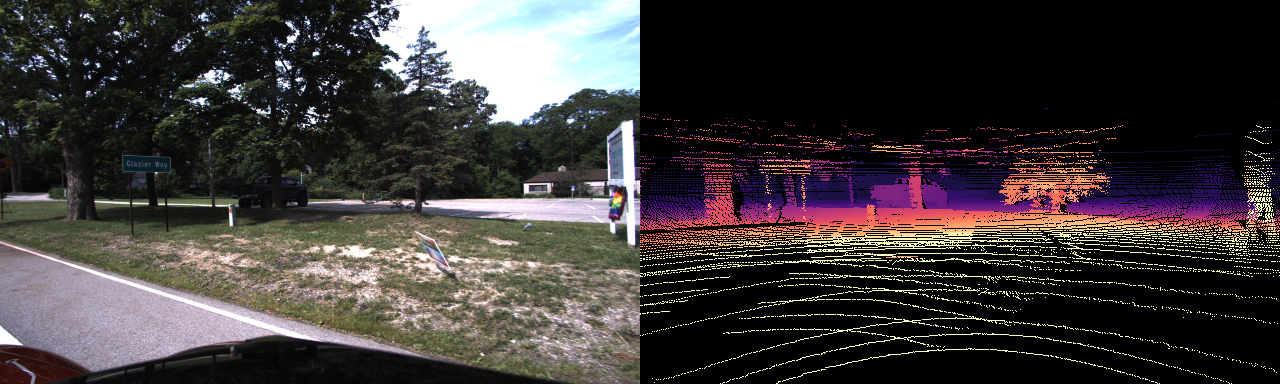

In [74]:
import matplotlib

def viz_depth(depth, background=(0, 0, 0)):
    # "depth == 0" means that there is no LiDAR point observed
    invalid = depth == 0

    inv_depth = 1. / depth.clip(1e-6, None)
    inv_depth[invalid] = 0.

    percentile = 80
    normalizer = np.percentile(inv_depth[inv_depth > 0], percentile)
    inv_depth = inv_depth / (normalizer + 1e-6)

    cmap = matplotlib.colormaps['magma']
    depth_colored = cmap(np.clip(inv_depth, 0., 1.0))[:, :, :3]
    depth_colored[invalid] = background

    return (depth_colored * 255.0).astype(np.uint8)

Image.fromarray(
    np.concatenate([image_camera['camera06'], viz_depth(depth_camera['camera06'])],axis=1)
)

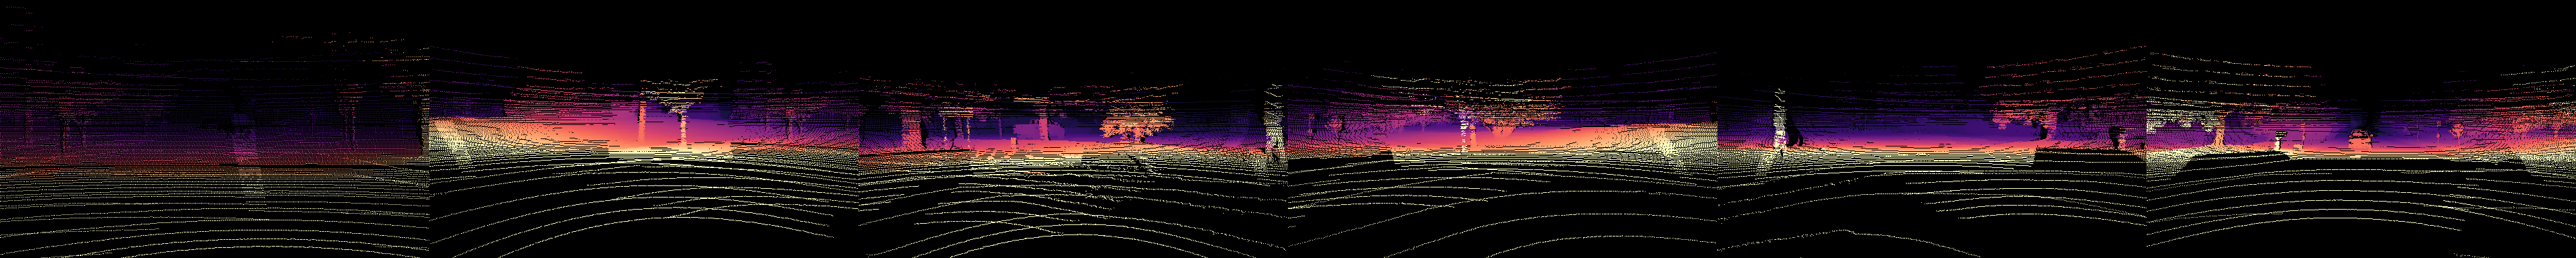

In [75]:
display(Image.fromarray(np.hstack(
    [viz_depth(depth_camera[f"camera{num:02d}"]) for num in camera_numbers]
)))


In [76]:
def get_pixel_grid(height, width, with_ones=True):
    """Create a pixel grid

    Parameters
    ----------
    height : int
        height of the grid
    width : int
        width of the grid        
    with_ones : Bool
        whether the ones are appended (homogeneous coordinate)

    Returns
    -------
    grid : np.ndarray (2 x H x W) or (3 x H x W)
        Output pixel grid
    """    
    xx, yy = np.meshgrid(
        np.linspace(0, width - 1, width),
        np.linspace(0, height - 1, height),        
        indexing='xy')    
    
    coords = [xx, yy]
    if with_ones:
        coords += [np.ones_like(xx)]
    grid = np.stack(coords, 0)
    return grid

In [77]:
def reconstruct_depth_map(depth, K, T_wc):
    """Reconstruct 3D points in world coordinate from depth map

    Parameters
    ----------
    depth : np.ndarray (H x W)
        input depth map
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_wc : np.ndarray (4 x 4)
        transformation to world coordinate from camera coordinate

    Returns
    -------
    points : np.ndarray (3 x H x W)
        output 3D points 
    """
    h, w = depth.shape
    K_inv = np.linalg.inv(K)  # (3 x 3)
    
    # Get a pixel grid (image coordinate)
    grid = get_pixel_grid(h, w, with_ones=True)
    grid = grid.reshape(3, -1)    # (3 x H x W) -> (3 x N)
        
    # Get 3D points in camera coordinate system
    #  - numpy broadcasting during element-wise multiplication
    #    : (1 x N) * (3 x N) -> (3 x N) (broadcasting) * (3 x N) -> (3 x N)
    pts3d_cam = depth.reshape(1, -1) * np.matmul(K_inv, grid)

    # Transform the coordinate, from camera to world
    pts3d_cam_homogeneous = np.concatenate([pts3d_cam, np.ones((1, h * w))], axis=0)
    pts3d_world = np.matmul(T_wc, pts3d_cam_homogeneous)
    pts3d_world = pts3d_world[:3]
    
    return pts3d_world.reshape(3, h, w)

In [78]:
import copy
import pythreejs as pjs

def visualize_3d(xyz, rgb=None, show_distance=None, size=0.03, height=960, width=1500):
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    # 거리 정보가 주어진 경우  [5,]
    if show_distance is not None:        
        dist = [show_distance] if not isinstance(show_distance, (tuple, list)) else show_distance

        angles = np.linspace(1, 360, 360 * 10)
        xx = np.array([d * np.cos(angles) for d in dist]).flatten()
        yy = np.array([d * np.sin(angles) for d in dist]).flatten()
        zz = np.zeros_like(xx)

        cc = np.zeros((len(xx), 3))
        cc[:, 0] = 1.0
        
        pts = np.concatenate([pts, np.stack([xx, yy, zz], axis=1)], axis=0)
        rgb = np.concatenate([rgb, cc], axis=0)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=3)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [79]:
T_lidar_from_camera = {}
pts3d_in_lidar_from_camera = {}
xyz3d ={}
rgb3d = {}

for num in camera_numbers:
    camera_id = f"camera{num:02d}"
    # 1. Reconstruct 3D points from frame 1 using depth + intrinsics + poses
    T_lidar_from_camera[camera_id] = np.matmul(np.linalg.inv(T_world_from_lidar), T_world_from_camera[camera_id])
    pts3d_in_lidar_from_camera[camera_id] = reconstruct_depth_map(depth_camera[camera_id], K_camera[camera_id], T_lidar_from_camera[camera_id])
    
    # 1-1. Visualize for debugging (should be a part of 1-2)
    xyz3d[camera_id] = pts3d_in_lidar_from_camera[camera_id].astype(np.float32)
    valid = depth_camera[camera_id] > 0

    rgb3d[camera_id] = image_camera[camera_id][valid].astype(np.float32) / 255.0
    xyz3d[camera_id] = xyz3d[camera_id][:, valid].T

# Image
# display(Image.fromarray(image_camera['camera06']).resize(size=(image_camera['camera06'].shape[1]//2, image_camera['camera06'].shape[0]//2)))

# Reconstructed 3D from depth map (in world coordinate system, which is the same with LiDAR coordinate system in this example)
# display(visualize_3d(xyz3d['camera08'], rgb3d['camera08'], size=0.2))


In [80]:
import numpy as np
import pythreejs as pjs
import torch
def visualize_3d_list(xyz_list, rgb_list, size=0.03, height=480, width=480):
    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointClouds = []
    for xyz, rgb in zip(xyz_list, rgb_list):
        points_buf = pjs.BufferAttribute(array=xyz)
        geometryAttrs = {'position': points_buf}

        colors_buf = pjs.BufferAttribute(array=rgb)
        geometryAttrs['color'] = colors_buf

        geometry = pjs.BufferGeometry(attributes=geometryAttrs)
        pointClouds.append(pjs.Points(geometry=geometry, material=material))

    pythreejs_camera = pjs.PerspectiveCamera(
        up=[1, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-30., 0., 60.)

    axes = pjs.AxesHelper(size=3)

    scene = pjs.Scene(children=pointClouds + [
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777'),
                    axes],
                    background = 'black')

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [81]:
import numpy as np

# 가정: xyz3d는 이미 각 카메라에 대해 계산된 3D 포인트를 LiDAR 좌표계로 나타내는 딕셔너리입니다.
# T_lidar_from_camera는 LiDAR 좌표계에서 각 카메라 좌표계로 변환하는 변환 행렬을 포함하는 딕셔너리입니다.

# 각 카메라에 대한 3D 포인트를 카메라 좌표계로 변환합니다.
xyz3d_in_camera = {}

for camera_id, T_lidar_to_camera in T_lidar_from_camera.items():
    # 포인트를 동차 좌표로 변환
    ones = np.ones((xyz3d[camera_id].shape[0], 1))
    homogeneous_points = np.hstack([xyz3d[camera_id], ones])
    
    # T_lidar_from_camera의 역변환을 사용하여 LiDAR 좌표계에서 카메라 좌표계로 변환
    T_camera_from_lidar = np.linalg.inv(T_lidar_to_camera)
    xyz3d_in_camera[camera_id] = (T_camera_from_lidar @ homogeneous_points.T).T[:, :3]

# 이제 xyz3d_in_camera 딕셔너리에는 각 카메라 좌표계에 대한 3D 포인트가 포함되어 있습니다.


In [82]:
print(xyz3d_in_camera)

{'camera01': array([[-14.3683,  -9.3195,  34.797 ],
       [-14.2824,  -9.3264,  34.8227],
       [-14.132 ,  -9.3228,  34.8091],
       ...,
       [  2.2549,   1.4114,   5.1588],
       [  2.2574,   1.4085,   5.1482],
       [  2.2708,   1.408 ,   5.1464]]), 'camera05': array([[-34.6156, -13.338 ,  38.05  ],
       [-34.5658, -13.4031,  38.2357],
       [-35.6873, -13.9262,  39.7278],
       ...,
       [ -2.0398,   1.484 ,   2.5107],
       [ -1.5411,   1.4743,   2.4943],
       [ -1.5295,   1.4769,   2.4986]]), 'camera06': array([[ 55.2404, -16.5288,  60.7066],
       [ 55.5131, -16.4557,  60.4381],
       [ 52.4049, -16.0172,  60.8315],
       ...,
       [  1.4473,   1.3982,   2.4626],
       [  1.9195,   1.3843,   2.438 ],
       [  1.9285,   1.3808,   2.4318]]), 'camera07': array([[ 34.8527, -13.51  ,  38.7752],
       [ 35.0264, -13.4916,  38.7224],
       [ 34.1633, -13.0766,  37.5312],
       ...,
       [ -1.2654,   1.4205,   2.5119],
       [ -0.1692,   1.4347,   2.5369],


In [83]:
import numpy as np

# 각 카메라에서 얻은 점과 색상 배열을 개별적으로 더하여 단일 배열로 만듭니다.
points_all = np.concatenate((xyz3d['camera01'], xyz3d['camera05'], xyz3d['camera06'], xyz3d['camera07'], xyz3d['camera08'], xyz3d['camera09']))
colors_all = np.concatenate((rgb3d['camera01'], rgb3d['camera05'], rgb3d['camera06'], rgb3d['camera07'], rgb3d['camera08'], rgb3d['camera09']))

# visualize_3d_list 함수를 호출하여 시각화합니다.
renderer = visualize_3d_list([points_all], [colors_all], size=0.3, height=960, width=1500)
renderer


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [84]:
print(extrinsics_camera)

{'camera01': {'rotation': {'qw': 0.512734825660536, 'qx': -0.5204131359731259, 'qy': 0.483559134543592, 'qz': -0.48212418510268484}, 'translation': {'x': 1.4855427639599839, 'y': 0.28616353316692766, 'z': 1.5617304615771417}}, 'camera05': {'rotation': {'qw': 0.6607769368469352, 'qx': -0.6751131476133265, 'qy': 0.23003455787756122, 'qz': -0.2338379349739517}, 'translation': {'x': 1.52093975696107, 'y': 0.4574157637366625, 'z': 1.5753242209317193}}, 'camera06': {'rotation': {'qw': 0.2256789490858021, 'qx': -0.22195853829756987, 'qy': 0.6685661783754228, 'qz': -0.6729210089964616}, 'translation': {'x': 1.5330512698187704, 'y': -0.4134779206162875, 'z': 1.5332483324642254}}, 'camera07': {'rotation': {'qw': 0.6700935030735806, 'qx': -0.6832162910666042, 'qy': -0.20377261275794284, 'qz': 0.2065597227185677}, 'translation': {'x': 1.1047227373333044, 'y': 0.4272270943622516, 'z': 1.563046883152822}}, 'camera08': {'rotation': {'qw': 0.21126882397726474, 'qx': -0.2086369912947377, 'qy': -0.67564

In [85]:
def T_orthogonal_to_cylindrical(xyz3d):
    r = np.sqrt((xyz3d[:,0])**2 + (xyz3d[:,2])**2)
    angle = np.arctan2(xyz3d[:,2], xyz3d[:,0])
    height = xyz3d[:,1]
    return r, angle, height

In [86]:
r={}
angle ={}
height={}
for num in camera_numbers:
    camera_id = f"camera{num:02d}"
    r[camera_id],angle[camera_id],height[camera_id] = T_orthogonal_to_cylindrical(xyz3d_in_camera[camera_id])

In [87]:
# 각 카메라에서 얻은 점과 색상 배열을 개별적으로 더하여 단일 배열로 만듭니다.
r_all = np.concatenate((r['camera01'], r['camera05'], r['camera06'], r['camera07'], r['camera08'], r['camera09']))
angle_all = np.concatenate((angle['camera01'], angle['camera05'], angle['camera06'], angle['camera07'], angle['camera08'], angle['camera09']))
z_all = np.concatenate((height['camera01'], height['camera05'], height['camera06'], height['camera07'], height['camera08'], height['camera09']))
r_all = torch.tensor(r['camera05'])
angle_all = torch.tensor(angle['camera05'])
z_all = torch.tensor(height['camera05'])

In [88]:
# print(min(angle['camera01']),max((angle['camera01'])))
# print(min(angle['camera05']),max((angle['camera05'])))
# print(min(angle['camera06']),max((angle['camera06'])))
# print(min(angle['camera07']),max((angle['camera07'])))
# print(min(angle['camera08']),max((angle['camera08'])))
# print(min(angle['camera09']),max((angle['camera09'])))

# ac1 = (min(angle['camera01'])+max((angle['camera01'])))/2
# ac6 = (min(angle['camera05'])+max((angle['camera05'])))/2
# ac8 = (min(angle['camera06'])+max((angle['camera06'])))/2
# ac9 = (min(angle['camera07'])+max((angle['camera07'])))/2
# ac7 = (min(angle['camera08'])+max((angle['camera08'])))/2
# ac5 = (min(angle['camera09'])+max((angle['camera09'])))/2
# ac15 = ac5-ac1
# ac17 = ac7-ac1
# ac19 = ac9-ac1
# ac16 = ac6-ac1
# ac18 = ac8-ac1
# print(ac19)


In [89]:

r_theta_z = torch.stack([r_all,angle_all,z_all]).T
print(r_theta_z)

tensor([[ 51.4397,   2.3090, -13.3380],
        [ 51.5438,   2.3058, -13.4031],
        [ 53.4030,   2.3027, -13.9262],
        ...,
        [  3.2348,   2.2531,   1.4840],
        [  2.9320,   2.1242,   1.4743],
        [  2.9295,   2.1201,   1.4769]], dtype=torch.float64)


In [90]:
import torch
import numpy as np

def create_depth_map(cylindrical_coords, image_width, image_height):
    # θ를 이미지의 너비에 맞게 조정
    theta_normalized = (cylindrical_coords[:, 1] + np.pi) / (2 * np.pi) * (image_width - 1)
    # z 값을 이미지 높이에 맞게 조정
    z_min = -0.2
    z_max = 0.2
    cylindrical_coords[:, 2] = cylindrical_coords[:, 2]/cylindrical_coords[:, 0]
    cylindrical_coords[:, 2] = torch.clamp(cylindrical_coords[:, 2], min=z_min, max=z_max)

    z_normalized = (cylindrical_coords[:, 2] + z_max) / (z_max - z_min) * (image_height - 1)

    depth_map = np.zeros((image_height, image_width))
    
    # 데이터 타입을 정수로 변환
    theta_normalized = theta_normalized.to(torch.int).numpy()
    z_normalized = z_normalized.to(torch.int).numpy()
    
    for i, (theta, z) in enumerate(zip(theta_normalized, z_normalized)):
        if 0 <= z < image_height and 0 <= theta < image_width:
            depth_map[z, theta] = cylindrical_coords[i, 0].item()

    return depth_map

In [91]:
depth_map = create_depth_map(r_theta_z, image_width=2048, image_height=256)
print(depth_map)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


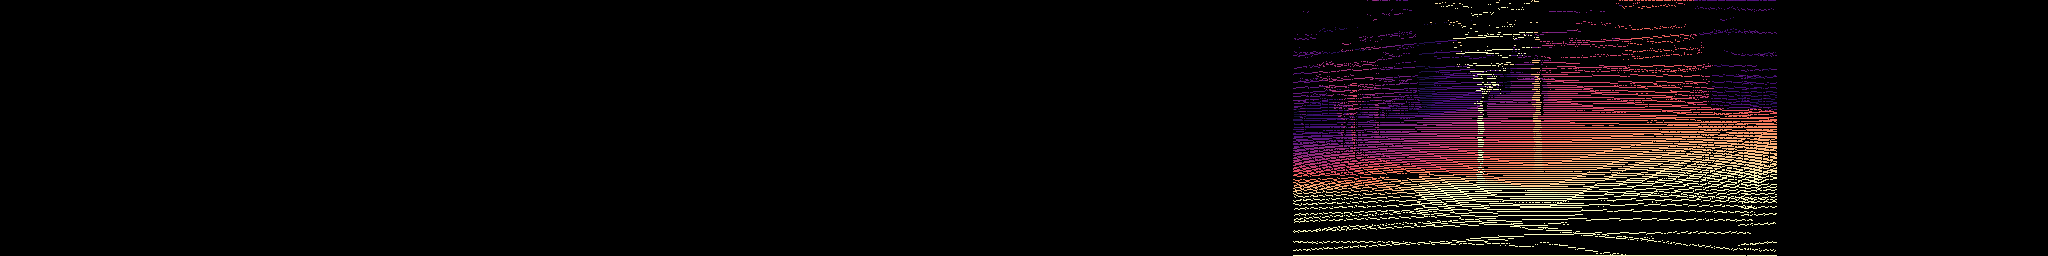

In [92]:
display(Image.fromarray(np.hstack(
    [viz_depth(depth_map)]
)))

In [93]:
def visualize_cylinder(r_all,angle_all,z_all, rgb=None, show_distance=None, size=0.03, height=960, width=1500):
    xx = 1 * np.cos(angle_all)
    yy = 1 * np.sin(angle_all)
    zz = z_all/r_all
    xyz = np.stack([xx, yy, zz], axis=1)
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-5., 0., 5.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=1)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [94]:
display(visualize_cylinder(r_all,angle_all, -z_all, rgb3d['camera01'], size=0.01))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [95]:
def unfold_cylinder(angle_all,z_all, rgb=None, show_distance=None, size=0.01, height=960, width=1500):
    
    yy = angle_all
    xx = np.ones_like(yy)
    zz = z_all/r_all
    xyz = np.stack([xx, yy, zz], axis=1)
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-5., 0., 5.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=1)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [96]:
unfold_cylinder(angle_all,z_all,colors_all)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [97]:
yy = angle_all
xx = np.ones_like(yy)
zz = z_all/r_all
xyz = np.stack([xx, yy, zz], axis=1)
pts = copy.deepcopy(xyz)
print(pts)

[[ 1.      2.309  -0.2593]
 [ 1.      2.3058 -0.26  ]
 [ 1.      2.3027 -0.2608]
 ...
 [ 1.      2.2531  0.4588]
 [ 1.      2.1242  0.5028]
 [ 1.      2.1201  0.5041]]


In [98]:
import matplotlib.pyplot as plt
# Define the cylindrical_to_image function as provided by the user
def cylindrical_to_image(theta, h, image_width, image_height):
    theta_n = (theta + np.pi) / (2 * np.pi)
    x_img = theta_n * image_width
    h_min, h_max = np.min(h), np.max(h)
    y_img = (h - h_min) / (h_max - h_min) * image_height
    return x_img,y_img
# Generate some example cylindrical coordinates


plt.figure(figsize=(32,4))
# Convert to image coordinates
image_width_example, image_height_example = 2048, 256  # Example image dimensions
x_img, y_img = cylindrical_to_image(angle_all, z_all, image_width_example, image_height_example)

# Plot the converted image cordinates
plt.scatter(x_img,y_img,c = colors_all,s=0.1)


TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


<Figure size 3200x400 with 0 Axes>

In [ ]:
# Note that this function takes "T_cw" not "T_wc"

def project_points_3d(pts3d_world, K, T_cw=np.eye(4)):
    """Project 3D points back to image plane (i.e. depth map)    

    Parameters
    ----------
    pts3d_world : np.ndarray (3 x H x W)
        input 3D points in world coordinate
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_cw : np.ndarray (4 x 4)
        transformation to camera coordinate from world coordinate, i.e., X_cam = T_cw @ X_world

    Returns
    -------
    coords : np.ndarray (2 x H x W)
        projected 2D coordinates
    depth : np.ndarray (H x W) 
        projected depth
    """
    
    h, w = pts3d_world.shape[1:]

    pts3d_world_homogeneous = np.concatenate([pts3d_world, np.ones((1, h, w))], axis=0)
    pts3d_cam = np.matmul(T_cw, pts3d_world_homogeneous.reshape(4, -1))   # (4 x N)    
    pts2d_img = np.matmul(K, pts3d_cam[:3])    # (3 x N)
    
    depth_on_camera = pts3d_cam[2].reshape(h, w)
    xx, yy, zz = pts2d_img.reshape(3, h, w)
    xx = (xx / zz + 1e-7).astype(np.int16)     
    yy = (yy / zz + 1e-7).astype(np.int16)         

    # The projected points are only valid if 
    #   1. the projected image coordinates are actually inside the image
    #   2. the depth of the 3D points in camera coordinate has positive value.
    #      (we cannot see the 3D points behind the image plane.)
    valid = np.logical_and.reduce([
        xx >= 0, xx < w,    # assume image sizes are always the same
        yy >= 0, yy < h,    # assume image sizes are always the same
        depth_on_camera > 0.0,
    ])
    
    coords = np.stack([xx, yy], axis=0)
    return coords, depth_on_camera, valid